# 3. Prédiction de la consommation totale d'énergie.

## 3.1. CHARGEMENT DES DONNÉES ET ANALYSE PRÉLIMINAIRE

In [1]:
import numpy as np
import pandas as pd
import mytools as mt
import matplotlib.pyplot as plt
import seaborn as sns

Commençons par importer le dataset des prédicteurs :

In [2]:
data_heavy = pd.read_csv('data_heavy.csv')
data_heavy.head()

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,source_energy_epoque,energy_epoque,electricity_epoque,gaz_epoque,emissions_epoque,source_energy_type,energy_type,electricity_type,gaz_type,emissions_type
0,47,29,98101.0,7,14,47.61220,-122.33799,1927,0.693147,2.564949,...,4.837075,14.667806,13.786284,12.815810,4.020160,5.127529,15.664266,14.992125,14.762854,5.323522
1,47,29,98101.0,7,14,47.61317,-122.33393,1996,0.693147,2.484907,...,5.367843,15.682288,15.263007,14.356420,4.759821,5.127529,15.664266,14.992125,14.762854,5.323522
2,47,29,98101.0,7,14,47.61393,-122.33810,1969,0.693147,3.737670,...,4.976044,14.755308,14.086287,13.490327,3.911823,5.127529,15.664266,14.992125,14.762854,5.323522
3,47,29,98101.0,7,14,47.61412,-122.33664,1926,0.693147,2.397895,...,4.939497,14.927433,14.464058,13.187216,4.256038,5.127529,15.664266,14.992125,14.762854,5.323522
4,47,29,98121.0,7,14,47.61375,-122.34047,1980,0.693147,2.944439,...,5.131672,14.838705,14.723476,13.187377,3.926517,5.127529,15.664266,14.992125,14.762854,5.323522


In [3]:
data_heavy.shape

(1637, 35)

Importons aussi le dataset initial qui contient notre cible :

In [4]:
data = pd.read_csv('data_initial.csv')
data.shape

(1637, 32)

Voici la cible :

In [5]:
y = data['SiteEnergyUse(kBtu)']       # La cible

In [6]:
mt.stats(y.to_frame())

,count,mean,std,min,25%,50%,75%,max
SiteEnergyUse(kBtu),1637.0,6879958.523,1.165153e+07,16809.0,1253745.5,2563985.5,6901554.0,98960776.0


### 3.1.1 CORRÉLATION DES PRÉDICTEURS AVEC LA CIBLE

Analysons les corrélations entre les prédicteurs et leur cible :

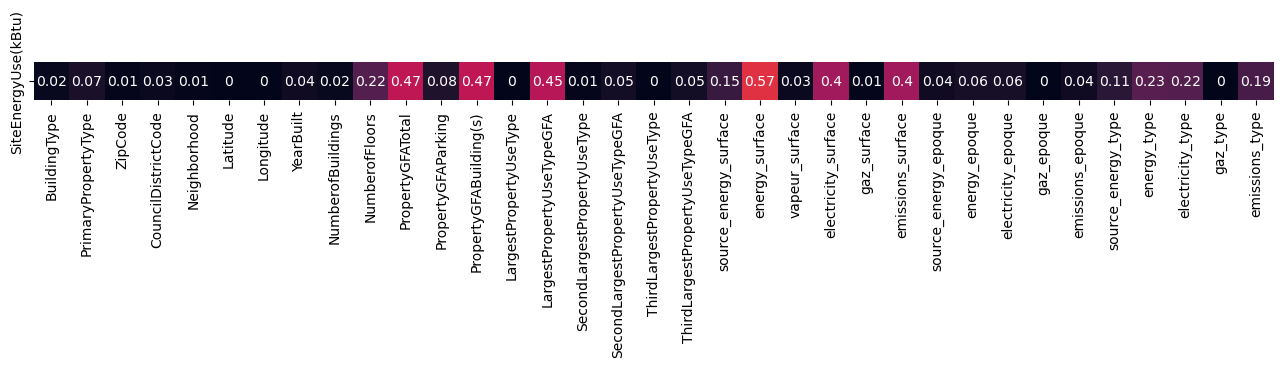

In [7]:
matrice_correlation = ((pd.concat([data_heavy, y], axis=1).corr()**2).round(2)).iloc[-1:,:-1]

plt.figure(figsize = (16,0.5))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

Cette cible est mieux corrélée aux prédicteurs que la précédente (non passée au log), on devrait donc observer une meilleur performance de la régression linéaire (meilleure que pour la cible précédente).

### 3.1.2 NORMALISATION DES PRÉDICTEURS

Normalisons les prédicteurs en utilisant la MinMaxScaler :

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_heavy)
scaled_data = pd.DataFrame(scaled_data, columns=data_heavy.columns)
mt.stats_extend(scaled_data)[['min','max']]

,min,max
BuildingType,0.0,1.0
PrimaryPropertyType,0.0,1.0
ZipCode,0.0,1.0
CouncilDistrictCode,0.0,1.0
Neighborhood,0.0,1.0
Latitude,0.0,1.0
Longitude,0.0,1.0
YearBuilt,0.0,1.0
NumberofBuildings,0.0,1.0
NumberofFloors,0.0,1.0


In [9]:
X = scaled_data

### 3.1.3 CRÉATION D'UN DATASET DE VALIDATION FINALE

Créons un dataset de validation finale avec 25% des données :

In [10]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
print(X.shape, X_val.shape)

(1227, 35) (410, 35)


## 3.2. MODÈLES LINÉAIRES

### 3.2.1 PRÉDICTION SUR LA CIBLE NON MODIFIÉE

Nous allons maintenant effectuer une recherche sur grille afin de trouver le modèle de regression linéaire régularisé (ElasticNet) optimal. Nous utiliserons à nouveau la MAPE afin d'évaluer les performances du modèle pour des raisons déjà expliquées.

In [11]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [13]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'alpha': np.logspace(-5, 5, 100),
              'l1_ratio': np.arange(0.1, 1.1, 0.1).round(1)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(ElasticNet(),                      # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e+16, tolerance: 1.304e+13
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.430e+16, tolerance: 1.448e+13
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.22051307399030456, 'l1_ratio': 0.1}


In [14]:
alpha_optimal = 0.22051307399030456
l1_ratio_optimal = 0.1

Testons ce modèle et évaluons sa performance à l'aide d'une validation croisée manuelle, en utilisant l'outil **KFold** de la bibliothèque `scikit-learn` :

In [15]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
model = ElasticNet(alpha=alpha_optimal, l1_ratio=l1_ratio_optimal)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(y_train, y_train_pred))
    erreur_test.append(mean_absolute_percentage_error(y_test, y_test_pred))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

erreur_train = 1.623778770724035
------------
erreur_test = 1.63829060164134


On obtient une erreur moyenne de 163% par prédiction. Ce résultat est meilleur que celui obtenu pour la cible précédente mais reste très décevant. Passons la cible au *log*.

### 3.2.2 PRÉDICTION SUR LA CIBLE PASSÉE AU *LOG*

Les nouveaux prédicteurs ont été passés au *log*, donc la cible passée au *log* leur est beaucoup mieux corrélée. Par conséquent, appliquer une transformation logarithmique à la cible devrait considérablement améliorer les performances de la régression linéaire. C'est ce que nous allons vérifier. Commençons par afficher la heatmap des corrélations entre les prédicteurs et la cible passée au *log* :

In [17]:
y_log = np.log(y+1)     # cible passée au log

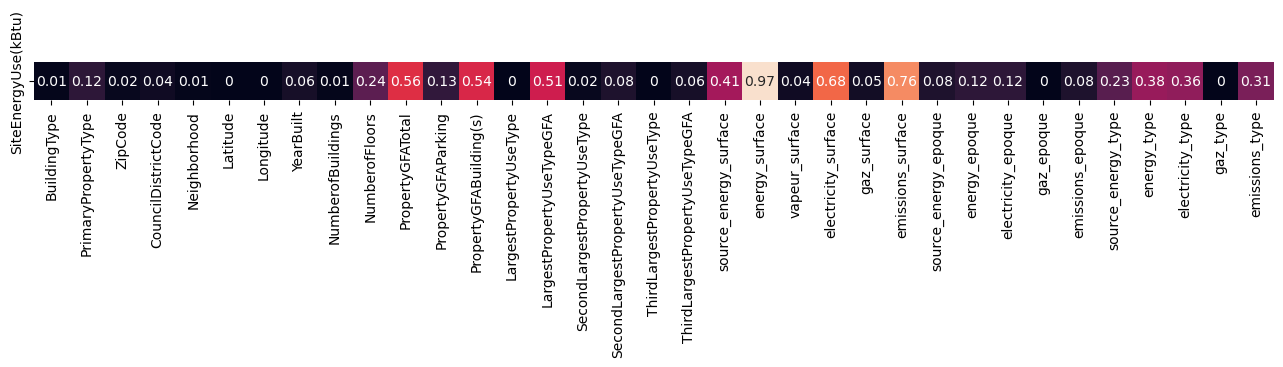

In [18]:
matrice_correlation = ((pd.concat([data_heavy, y_log], axis=1).corr()**2).round(2)).iloc[-1:,:-1]

plt.figure(figsize = (16,0.5))
sns.heatmap(matrice_correlation, vmin=0, vmax=1, annot=True, cbar=False)
plt.show()

On observe une bien meilleure corrélation entre les prédicteurs et la cible. En particulier, la variable *energy_surface* est quasi-parfaitement corrélée à la cible et devrait considérablement accroître les performances de la régression linéaire.

Nous allons à nouveau mettre en place une recherche sur grille pour trouver l'ElasticNet optimal et évaluer sa performance :

In [19]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'alpha': np.logspace(-5, 5, 100),
              'l1_ratio': np.arange(0.1, 1.1, 0.1).round(1)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(ElasticNet(),                      # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e+00, tolerance: 1.625e-01
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.110e-01, tolerance: 1.685e-01
  model = cd_fast.enet_coordinate_descent(
/home/chakir/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0026560877829466868, 'l1_ratio': 1.0}


In [20]:
alpha_optimal = 0.0026560877829466868
l1_ratio_optimal = 1

Le modèle optimal est un pur Lasso. Pour évaluer correctement sa performance, il nous faut mesurer l'erreur entre la variable prédite et la cible ***toutes-deux passées à l'exponentielle***, c'est à dire mesurer l'erreur avec la cible initiale.

In [21]:
model = Lasso(alpha=alpha_optimal)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

erreur_train = 0.06941477078235932
------------
erreur_test = 0.06999044440944982


La performance est excellente et le modèle n'overfit pas ! 

Nous allons maintenant implémenter des modèles plus complexes. Nous allons tous les tester cette fois ***avec le logarithme de la cible***.

## 3.3. MODÈLES À ARBRES

### 3.3.1 ARBRE DE DÉCISION

In [22]:
from sklearn.tree import DecisionTreeRegressor

In [23]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'max_depth': range(1,101)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(DecisionTreeRegressor(),           # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 41}


In [24]:
model = DecisionTreeRegressor(max_depth=41, random_state=72)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

erreur_train = 0.0
------------
erreur_test = 0.16403864410956986


L'arbre de décision proposé par la grille de recherche est assez performant, mais moins que le Lasso précédent. Par ailleurs il overfit beaucoup. Le Lasso reste donc favori.

### 3.3.2 FORÊT ALÉATOIRE

In [25]:
from sklearn.ensemble import RandomForestRegressor
import time

In [26]:
debut = time.time()

# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'n_estimators': range(10,201,10), 
              'max_depth': range(1,11)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(RandomForestRegressor(),           # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'max_depth': 7, 'n_estimators': 140}
Durée d'exécution : 723.7179837226868 secondes


La recherche précédente a duré 12min03s. Évaluons la performance du modèle trouvé :

In [27]:
debut = time.time()

model = RandomForestRegressor(n_estimators=140, max_depth=7, random_state=72)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print('------------')
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.0447147650710167
------------
erreur_test = 0.10345913232235901
------------
Durée d'exécution : 5.638794422149658 secondes


La forêt aléatoire proposée par la grille de recherche est moins performante que le Lasso et overfit légèrement. Le Lasso est à privilégier.

### 3.3.3 GRADIENT BOOST

In [29]:
from sklearn.ensemble import GradientBoostingRegressor

In [30]:
debut = time.time()

# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'learning_rate': np.arange(0.1, 1.1, 0.1).round(1),
              'n_estimators': range(10,121,10),
              'max_depth': range(1,11)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(GradientBoostingRegressor(),       # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 40}
Durée d'exécution : 3411.1833078861237 secondes


La recherche précédente a duré 56min51s ! Évaluons le modèle trouvé :

In [31]:
debut = time.time()

model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=40, max_depth=3, random_state=72)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
        
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

# Durée d'exécution :
duree = fin - debut
print('------------')
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.06945075829754076
------------
erreur_test = 0.10043120716641578
------------
Durée d'exécution : 1.050746202468872 secondes


Les performances sont similaires à celles de la forêt aléatoire précédente. Le Lasso reste préférable. C'est le modèle que nous retenons donc.

## 3.4 FINE TUNING ET VALIDATION FINALE

Nous allons à nouveau lancer une *GridSearchCV* avec des hyperparamètres à tester voisins de ceux trouvés pour l'ElasticNet précédemment :

In [32]:
# Fixer les valeurs des hyperparamètres à tester :
param_grid = {'alpha': np.arange(0.0020, 0.0031, 0.0001).round(4),
              'l1_ratio': np.arange(0.90, 1.01, 0.01).round(2)}

# Choisir le score à optimiser :
score = 'neg_mean_absolute_percentage_error'

# Créer un regresseur avec recherche d'hyperparamètres par validation croisée :
model = GridSearchCV(ElasticNet(),                      # choix du modèle
                     param_grid,                        # hyperparamètres à tester
                     cv=5,                              # nombre de plis pour la validation croisée
                     scoring=score)                     # score à optimiser

# Optimiser ce modèle sur le jeu d'entraînement :
model.fit(X, y_log)

# Afficher le(s) hyperparamètre(s) optimaux :
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(model.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'alpha': 0.0026, 'l1_ratio': 1.0}


Nous obtenons comme modèle final un Lasso avec un $\alpha$ de 0.026. Nous allons à nouveau évaluer sa performance, via une validation croisée manuelle :

In [33]:
debut = time.time()

model = Lasso(alpha=0.0026)

erreur_train = []
erreur_test = []
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y_log.iloc[train_index], y_log.iloc[test_index]
    
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)    
    y_test_pred = model.predict(X_test)

    erreur_train.append(mean_absolute_percentage_error(np.exp(y_train)-1, np.exp(y_train_pred)-1))
    erreur_test.append(mean_absolute_percentage_error(np.exp(y_test)-1, np.exp(y_test_pred)-1))

print(f"erreur_train = {np.mean(erreur_train)}")
print('------------')
print(f"erreur_test = {np.mean(erreur_test)}")

fin = time.time()

print('------------')
duree = fin - debut
print(f"Durée d'exécution : {duree} secondes")

erreur_train = 0.06936526436091317
------------
erreur_test = 0.06994270632996433
------------
Durée d'exécution : 0.04001879692077637 secondes


Le résultat est plus que satisfaisant : nous avons trouvé un modèle simple, rapide, robuste et performant !

Nous allons maintenant l'évaluer sur le dataset de validation finale :

In [34]:
y_val_pred = model.predict(X_val)

print(f"erreur = {mean_absolute_percentage_error(y_val, np.exp(y_val_pred)-1)}")

erreur = 0.09355232586719464


Excellent !

Enregistrons les paramètres du modèle (coefficients de la régression) :

In [35]:
poids_lasso_energie = model.coef_

## 3.5 FEATURE IMPORTANCE

Bien que la libraire Shap ne soit pas indispensable pour comprendre les features importances dans notre cas, nous allons quand même l'utiliser. Cette libraire est surtout utile pour les modèles plus complexes dont le fonctionnement interne et plus difficile à cerner (boîte noire). Commençons par afficher le graphique de l'importance globale de chaque feature :

In [36]:
import shap

shap.initjs() # Initialisation de JavaScript pour pouvoir tracer des graphiques avec Shap

In [37]:
explainer = shap.LinearExplainer(model, X_test)

In [38]:
# Calcul des valeurs SHAP pour toutes les observations de l'ensemble de test (le dernier)
shap_values = explainer.shap_values(X_test)

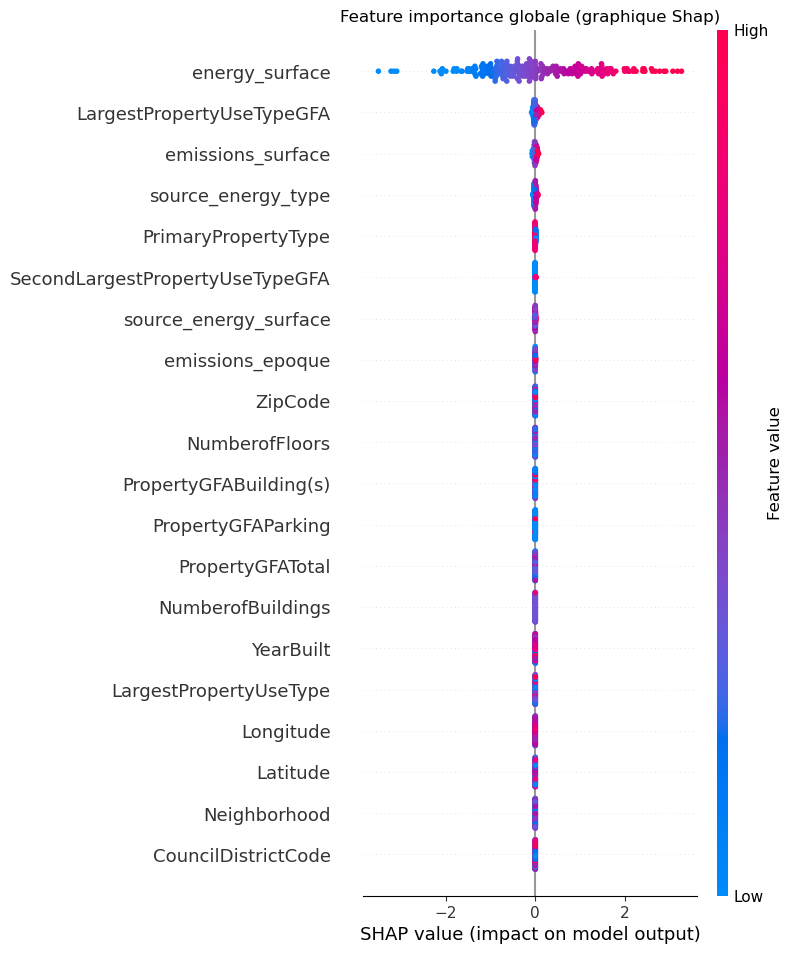

In [39]:
# Résumé global de l'importance des caractéristiques (graphique Shap):
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title('Feature importance globale (graphique Shap)')
plt.show()

On peut voir l'écrasante contribution du prédicteur *energy_surface* comme prévu.

In [40]:
observation_index = range(200)
x_observation = X_test.iloc[observation_index]

# Force plot pour l'observation sélectionnée
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[observation_index, :], x_observation)

On peut faire les mêmes observations que pour la cible précédente, mais cette fois avec le prédicteur *energy_surface*.